# TFM - Performance assessment of the Android 12 positioning capabilities

### Master's degree in Advanced Telecommunication Technologies (MATT)

##### Diogo Corrêa Oliveira (diogo.correa@estudiantat.upc.edu)

In [202]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import math

#Read csv file with measurements results into dataframe
data = pd.read_csv("database/measurements.csv", sep=';')
df = pd.DataFrame(data)

### General Parameters

In [165]:
# Mapping Acess Point (AP) to the MAC
apDict = {
    "GRXCA-G06 (5180MHz)":"cc:f4:11:47:ef:e7#1",
    "GRXCA-L05 (5540MHz)":"c4:41:1e:fa:07:db#1",
    "GRXCA-L05 (5240MHz)":"c4:41:1e:fa:07:da#1",
    "GRXCA-G06 (2462MHz)":"cc:f4:11:47:ef:eb#1",
    "GRXCA-L05 (2427MHz)":"c4:41:1e:fa:07:d9#1"
}

# Mapping User Equipment (UE) and code used by the APP
ueDict = {
    "Pixel 4a":"Pixel 4a",
    "Pixel 3a":"Pixel 3a",
    "Pixel 6 Pro":"Pixel 6 Pro",
    "Xiaomi Mi 10T":"M2007J3SY"
}

# List with reference points' coordinates
yCoordinateList = list(range(1, 26))

# List with the burst size range [min:2, max: 29]
burstSizeList = list(range(2, 30, 3))

#Defining burst Size
burstSize = 8

#Defining quantile
quantile = 0.9

### Measurement Scenario

<table>
<tr>
<td> <img src="./images/1.jpg" width="125" height="125"/> </td>
<td> <img src="./images/2.jpg" width="125" height="125"/> </td>
<td> <img src="./images/3.jpg" width="125" height="125"/> </td>
<td> <img src="./images/4.jpg" width="125" height="125"/> </td>
<td> <img src="./images/5.jpg" width="125" height="125"/> </td>
</tr>
<tr>
<td> <img src="./images/6.jpg" width="125" height="125"/> </td>
<td> <img src="./images/7.jpg" width="125" height="125"/> </td>
<td> <img src="./images/8.jpg" width="125" height="125"/> </td>
<td> <img src="./images/9.jpg" width="125" height="125"/> </td>
<td> <img src="./images/10.jpg" width="125" height="125"/> </td>
</tr>
<tr>
<td> <img src="./images/11.jpg" width="125" height="125"/> </td>
<td> <img src="./images/12.jpg" width="125" height="125"/> </td>
<td> <img src="./images/13.jpg" width="125" height="125"/> </td>
<td> <img src="./images/14.jpg" width="125" height="125"/> </td>
<td> <img src="./images/15.jpg" width="125" height="125"/> </td>
</tr>
<tr>
<td> <img src="./images/16.jpg" width="125" height="125"/> </td>
<td> <img src="./images/17.jpg" width="125" heigh="125"/> </td>
<td> <img src="./images/18.jpg" width="125" height="125"/> </td>
<td> <img src="./images/19.jpg" width="125" height="125"/> </td>
<td> <img src="./images/20.jpg" width="125" height="125"/> </td>
</tr>
<tr>
<td> <img src="./images/21.jpg" width="125" height="125"/> </td>
<td> <img src="./images/22.jpg" width="125" heigh="125"/> </td>
<td> <img src="./images/23.jpg" width="125" height="125"/> </td>
<td> <img src="./images/24.jpg" width="125" height="125"/> </td>
<td> <img src="./images/25.jpg" width="125" height="125"/> </td>
</tr>
</table>

## Formating Data Frame (internal function)

In [166]:
def formatDataFrame(targetModel, targetAP, burstSize):
    ##Filtering UE model and removing samples not collected for specific AP
    filtered_campaign_df = df.loc[(df['model'] == targetModel) & (df[targetAP] != -100)]
    #Selecting collumns
    filtered_campaign_df  = filtered_campaign_df[['y','angle','sampleNumber',targetAP]].sort_values(by=['y','angle','sampleNumber'])
    #Removing issue with 11m measurement
    filtered_campaign_df['y'] = round(filtered_campaign_df['y'],2)

    return filtered_campaign_df

## Plotting Error

In [167]:
def plotError(targetModel, targetAP, burstSize, color):
    
    filtered_campaign_df = formatDataFrame(targetModel, targetAP, burstSize)
    
    #Calculating absolute error
    filtered_campaign_abs_error_df = filtered_campaign_df.copy()
    filtered_campaign_abs_error_df[targetAP] = filtered_campaign_abs_error_df[targetAP]-filtered_campaign_abs_error_df['y']
    
    #Plotting absolute measurements error
    abs_error_df = filtered_campaign_abs_error_df.loc[filtered_campaign_abs_error_df['angle']==burstSize]
    ax = abs_error_df.plot(kind="scatter",x="y",y=targetAP,color=color,grid=True,label=targetModel+'\n'+ targetAP +'\n'+ "Burst Size = " + str(burstSize))
    ax.set_title('Distance Absolute Error')
    ax.set_ylabel("Absolute Error (m)")
    ax.set_xlabel("Real Distance (m)")
    plt.show()
    
    #Percentage of under-2M error for estimated distances
    print("["+targetModel+"]"+"Percentage of under-2M error for estimated distance:" +str(round(len(abs_error_df[targetAP].loc[abs(abs_error_df[targetAP])<=2])/len(abs_error_df[targetAP]),4)))
    
    # Density plot mean absolute error - window = 200
    mean_error_df = filtered_campaign_abs_error_df[targetAP].rolling(window=200).mean()
    ax2 = mean_error_df.plot.density(color='b',grid=True)
    #ax2.set_xticks(np.arange(round(min(filtered_campaign_abs_error_df[targetAP])-2), round(max(filtered_campaign_abs_error_df[targetAP])+2), 1.0))
    ax2.set_xticks(np.arange(-6,7, 1.0))
    ax2.set_title('Mean Absolute Error'+'\n'+ targetModel+'\n'+ targetAP +'\n'+ "Burst Size = " + str(burstSize))
    ax2.set_ylabel("Density")
    ax2.set_xlabel("Distance error (m)")   
    plt.show()

## Plotting Trend

In [168]:
def plotTrend(targetModel, targetAP, burstSize, color):
    
    filtered_campaign_df = formatDataFrame(targetModel, targetAP, burstSize)
    
    #Plotting measurements trend
    result_df = filtered_campaign_df.loc[filtered_campaign_df['angle']==burstSize].rolling(window=200).mean()
    ax = result_df.plot(x="y",y=targetAP, color=color, label=targetModel+'\n'+ targetAP +'\n'+ "Burst Size = " + str(burstSize))
    result_df = filtered_campaign_df.loc[filtered_campaign_df['angle']==burstSize]
    result_df.plot(kind="scatter",x="y",y="y", color="g", label="Reference", grid=True, ax=ax)
    ax.set_xlabel("Real Distance")
    ax.set_ylabel("Measured Distance")
    plt.show()

## Plotting Error removing bias

In [169]:
def plotErrorBias(targetModel, targetAP, burstSize,bias, color):
    
    filtered_campaign_df = formatDataFrame(targetModel, targetAP, burstSize)
    
    #Calculating absolute error
    filtered_campaign_abs_error_df = filtered_campaign_df.copy()
    filtered_campaign_abs_error_df[targetAP] = filtered_campaign_abs_error_df[targetAP]-filtered_campaign_abs_error_df['y']-bias
    
    #Plotting absolute measurements error
    abs_error_df = filtered_campaign_abs_error_df.loc[filtered_campaign_abs_error_df['angle']==burstSize]
    ax = abs_error_df.plot(kind="scatter",x="y",y=targetAP,color=color,grid=True,label=targetModel+'\n'+ targetAP +'\n'+ "Burst Size = " + str(burstSize))
    ax.set_title('Distance Absolute Error')
    ax.set_ylabel("Absolute Error (m)")
    ax.set_xlabel("Real Distance (m)")
    plt.show()
    
    #Percentage of under-2M error for estimated distances
    print("["+targetModel+"]"+"Percentage of under-2M error for estimated distance:" +str(round(len(abs_error_df[targetAP].loc[abs(abs_error_df[targetAP])<=2])/len(abs_error_df[targetAP]),4)))
        
    # Density plot mean absolute error - window = 200
    mean_error_df = filtered_campaign_abs_error_df[targetAP].rolling(window=200).mean()
    ax2 = mean_error_df.plot.density(color='b',grid=True,label=targetModel+'\n'+ targetAP +'\n'+ "Burst Size = " + str(burstSize))
    ax2.set_xticks(np.arange(-6,7, 1.0))
    ax2.set_title('Mean Absolute Error'+'\n'+ targetModel+'\n'+ targetAP +'\n'+ "Burst Size = " + str(burstSize))
    ax2.set_ylabel("Density")
    ax2.set_xlabel("Distance error (m)")

## Plotting Trend removing bias

In [170]:
def plotTrendBias(targetModel, targetAP, burstSize,bias, color):
    
    filtered_campaign_df = formatDataFrame(targetModel, targetAP, burstSize)
    filtered_campaign_df_bias = filtered_campaign_df.copy()
    
    #Plotting measurements trend
    filtered_campaign_df_bias[targetAP] = filtered_campaign_df_bias[targetAP]-bias
    result_df = filtered_campaign_df_bias.loc[filtered_campaign_df_bias['angle']==burstSize].rolling(window=200).mean()
    ax = result_df.plot(x="y",y=targetAP, color=color, label=targetModel+'\n'+ targetAP +'\n'+ "Burst Size = " + str(burstSize))
    result_df = filtered_campaign_df.loc[filtered_campaign_df['angle']==burstSize]
    result_df.plot(kind="scatter",x="y",y="y", color="g", label="Reference", grid=True, ax=ax)
    ax.set_xlabel("Real Distance")
    ax.set_ylabel("Measured Distance")
    plt.show()

## Calculating Standard Deviation

In [203]:
#Stadard deviation of all 25 reference points
def calculateStandardDeviation(targetModel, targetAP, burstSize):
    filtered_campaign_df = formatDataFrame(targetModel, targetAP, burstSize)
    filtered_campaign_df = filtered_campaign_df.loc[filtered_campaign_df['angle']==burstSize]
    result_std = []
    result_std_rmv_nan = []
    for i in range(1,26):
        perReferencePoint_df = filtered_campaign_df.loc[filtered_campaign_df['y']==i]
        stdValue = perReferencePoint_df[targetAP].std()
        result_std.append(stdValue)
        if(not math.isnan(stdValue)):
            result_std_rmv_nan.append(stdValue)
        print("std reference point " +str(i)+": "+str(stdValue))
    print("Max std " +targetModel+": "+str(round(np.max(result_std),4)))
    print("Mean std " +targetModel+": "+str(round(np.mean(result_std),4)))
    if(targetModel == "Pixel 4a"):
        print("Max std " +targetModel+": "+str(round(np.max(result_std_rmv_nan),4)))
        print("Mean std " +targetModel+": "+str(round(np.mean(result_std_rmv_nan),4)))

## Calculating the 90th percentile

In [172]:
def calculateQuantile(targetModel, targetAP, burstSize,quantile,color):
    
    filtered_campaign_df = formatDataFrame(targetModel, targetAP, burstSize)
    
    #Calculating absolute error
    filtered_campaign_abs_error_df = filtered_campaign_df.copy()
    filtered_campaign_abs_error_df[targetAP] = filtered_campaign_abs_error_df[targetAP]-filtered_campaign_abs_error_df['y']
    abs_error_df = filtered_campaign_abs_error_df.loc[filtered_campaign_abs_error_df['angle']==burstSize]
    
    referencePoints = list(range(1, 26))
    result = []
    
    for i in range(1,26):
        perReferencePoint_df = abs_error_df.loc[filtered_campaign_abs_error_df['y']==i]
        result.append(perReferencePoint_df[targetAP].quantile(q=quantile))

    df = pd.DataFrame({'Real Distance (m)': referencePoints, 'quantile': np.abs(result)},columns = ['Real Distance (m)', 'quantile'])

    ax = df.plot(kind="line",x='Real Distance (m)',y='quantile',label=targetModel,color=color,grid=True)
    ax.set_title('90th percentile')
    ax.set_yticks(np.arange(0,7,0.5))
    ax.set_ylabel("Absolute Error (m)")
    ax.set_xlabel("Real Distance (m)")

## Calculating the 90th percentile removing bias

In [173]:
def calculateQuantileBias(targetModel, targetAP, burstSize,quantile,color,bias):
    
    filtered_campaign_df = formatDataFrame(targetModel, targetAP, burstSize)
    filtered_campaign_df_bias = filtered_campaign_df.copy()
    filtered_campaign_df_bias[targetAP] = filtered_campaign_df_bias[targetAP]-bias
    
    #Calculating absolute error
    filtered_campaign_abs_error_df = filtered_campaign_df_bias.copy()
    filtered_campaign_abs_error_df[targetAP] = filtered_campaign_abs_error_df[targetAP]-filtered_campaign_abs_error_df['y']
    abs_error_df = filtered_campaign_abs_error_df.loc[filtered_campaign_abs_error_df['angle']==burstSize]
    
    referencePoints = list(range(1, 26))
    result = []
    
    for i in range(1,26):
        perReferencePoint_df = abs_error_df.loc[filtered_campaign_abs_error_df['y']==i]
        result.append(perReferencePoint_df[targetAP].quantile(q=quantile))

    df = pd.DataFrame({'Real Distance (m)': referencePoints, 'quantile': np.abs(result)},columns = ['Real Distance (m)', 'quantile'])
    ax = df.plot(kind="line",x='Real Distance (m)',y='quantile',label=targetModel,color=color,grid=True)
    ax.set_title('90th percentile')
    ax.set_yticks(np.arange(0,7,0.5))
    ax.set_ylabel("Absolute Error (m)")
    ax.set_xlabel("Real Distance (m)")

###  Pixel 3a - GRXCA-G06 (5180MHz) - Busrt Size = 8 

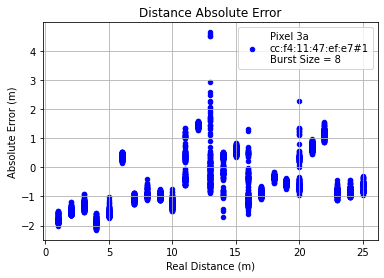

[Pixel 3a]Percentage of under-2M error for estimated distance:0.9928


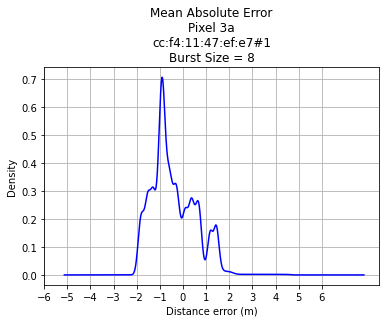

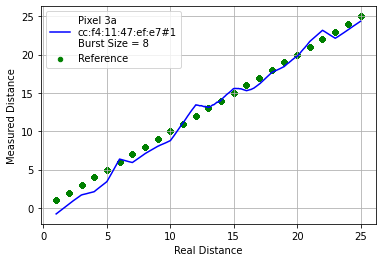

std reference point 1: 0.09669841203167319
std reference point 2: 0.08780711558717035
std reference point 3: 0.11872376187253261
std reference point 4: 0.11657182055168247
std reference point 5: 0.10281912889307931
std reference point 6: 0.0815370920927076
std reference point 7: 0.08339565502100157
std reference point 8: 0.10806419969759372
std reference point 9: 0.08181185042123633
std reference point 10: 0.13420657556402782
std reference point 11: 0.5500318655912848
std reference point 12: 0.05911225990737254
std reference point 13: 0.989719208428665
std reference point 14: 0.4685463241659753
std reference point 15: 0.10967807609948503
std reference point 16: 0.6101108721219505
std reference point 17: 0.08995640471219218
std reference point 18: 0.06364092975199583
std reference point 19: 0.06925816534775321
std reference point 20: 0.5999319525692624
std reference point 21: 0.11660428937868263
std reference point 22: 0.13091790659161828
std reference point 23: 0.11078172436038955
std 

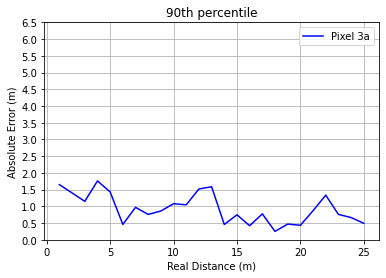

In [174]:
# Defining target UE
targetModel = ueDict["Pixel 3a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (5180MHz)"]

#Defining Color of the plot
color = "b"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

<b> Observation: </b> It seems to follow the trend whithin a 2m error range.

###  Pixel 3a - GRXCA-L05 (5540MHz) - Busrt Size = 8 

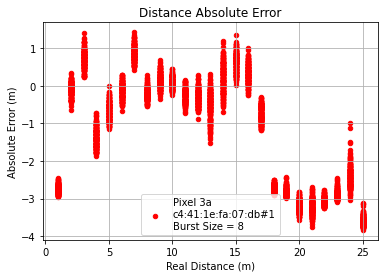

[Pixel 3a]Percentage of under-2M error for estimated distance:0.643


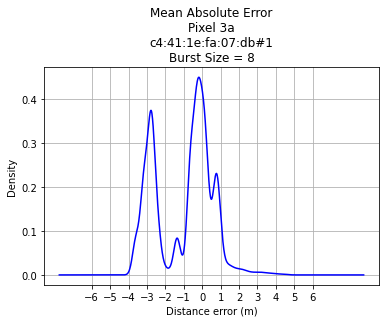

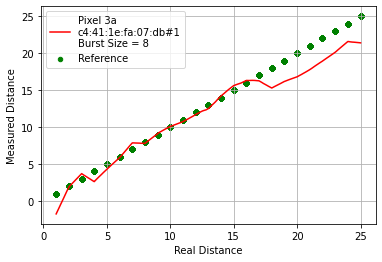

std reference point 1: 0.10103568154233245
std reference point 2: 0.1718180479694732
std reference point 3: 0.22782763717623575
std reference point 4: 0.24099237795240697
std reference point 5: 0.23232358541850323
std reference point 6: 0.1946208373392561
std reference point 7: 0.1925530909624563
std reference point 8: 0.144702321280343
std reference point 9: 0.187877954344418
std reference point 10: 0.13564128118240407
std reference point 11: 0.17639232020737397
std reference point 12: 0.2083707195332251
std reference point 13: 0.35416853265445974
std reference point 14: 0.37176612950919996
std reference point 15: 0.2470629484615461
std reference point 16: 0.2388130218329496
std reference point 17: 0.21217872900034312
std reference point 18: 0.09146839185501571
std reference point 19: 0.09936838104122345
std reference point 20: 0.15625697942201
std reference point 21: 0.19837332831541313
std reference point 22: 0.09902421611345592
std reference point 23: 0.1069176285580748
std referen

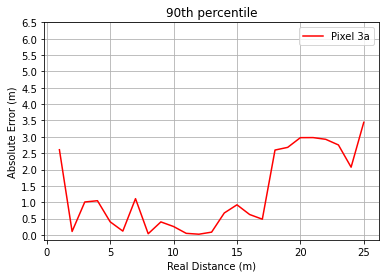

In [175]:
# Defining target UE
targetModel = ueDict["Pixel 3a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (5540MHz)"]

#Defining Color of the plot
color = "r"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

<b> Observation: </b> Not really
sure what happened from reference point 18 to 25. It seems that the accuracy of the measurements decreased significanly. This results is not consistent with other devices for the same frequency band. Apart from this, the trend seems to follow the real distance.

###  Pixel 3a - GRXCA-L05 (5240MHz)- Busrt Size = 8 

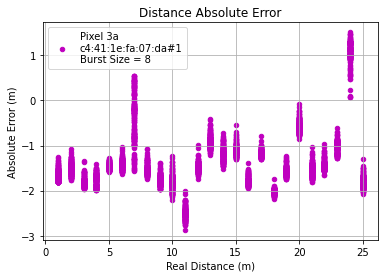

[Pixel 3a]Percentage of under-2M error for estimated distance:0.9268


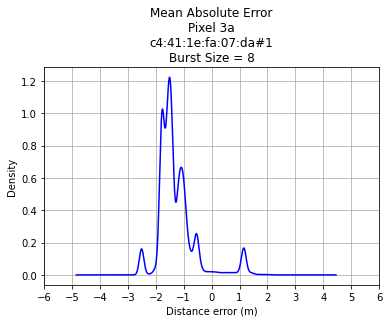

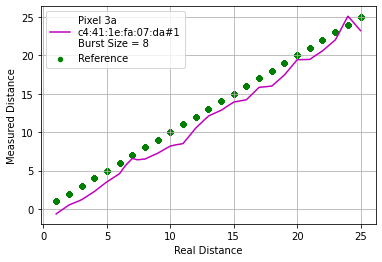

std reference point 1: 0.11826113671568708
std reference point 2: 0.12853649257943486
std reference point 3: 0.09726671498627423
std reference point 4: 0.12995292692386887
std reference point 5: 0.059564199350122256
std reference point 6: 0.0940500433453719
std reference point 7: 0.5673083867070368
std reference point 8: 0.112608417440225
std reference point 9: 0.11232944984066968
std reference point 10: 0.17072582496962135
std reference point 11: 0.12577775715912531
std reference point 12: 0.09825928114767729
std reference point 13: 0.13851141119110277
std reference point 14: 0.15160180908415283
std reference point 15: 0.1152679024999313
std reference point 16: 0.09241759048011776
std reference point 17: 0.07359606428601984
std reference point 18: 0.05157645834367036
std reference point 19: 0.09040772732905115
std reference point 20: 0.12972462484608424
std reference point 21: 0.13229694177878826
std reference point 22: 0.1004465281885125
std reference point 23: 0.13064000326186997
st

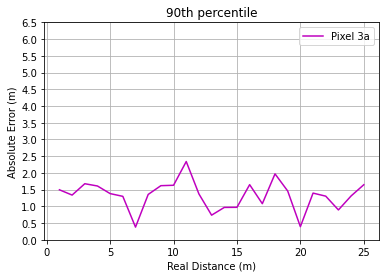

In [176]:
# Defining target UE
targetModel = ueDict["Pixel 3a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (5240MHz)"]

#Defining Color of the plot
color = "m"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

###  Removing bias

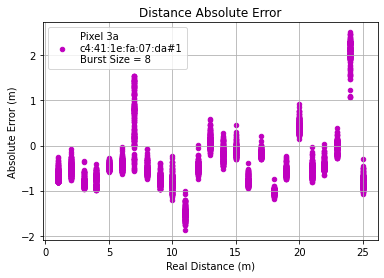

[Pixel 3a]Percentage of under-2M error for estimated distance:0.97


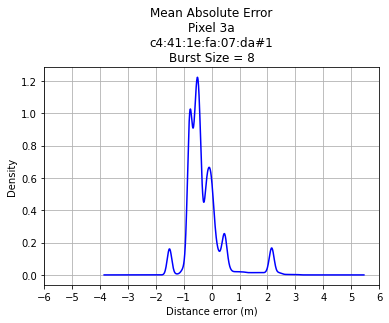

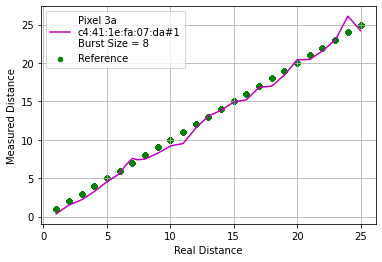

std reference point 1: 0.11826113671568708
std reference point 2: 0.12853649257943486
std reference point 3: 0.09726671498627423
std reference point 4: 0.12995292692386887
std reference point 5: 0.059564199350122256
std reference point 6: 0.0940500433453719
std reference point 7: 0.5673083867070368
std reference point 8: 0.112608417440225
std reference point 9: 0.11232944984066968
std reference point 10: 0.17072582496962135
std reference point 11: 0.12577775715912531
std reference point 12: 0.09825928114767729
std reference point 13: 0.13851141119110277
std reference point 14: 0.15160180908415283
std reference point 15: 0.1152679024999313
std reference point 16: 0.09241759048011776
std reference point 17: 0.07359606428601984
std reference point 18: 0.05157645834367036
std reference point 19: 0.09040772732905115
std reference point 20: 0.12972462484608424
std reference point 21: 0.13229694177878826
std reference point 22: 0.1004465281885125
std reference point 23: 0.13064000326186997
st

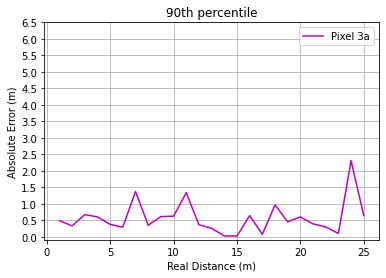

In [177]:
# Defining target UE
targetModel = ueDict["Pixel 3a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (5240MHz)"]

#Defining Color of the plot
color = "m"

#Defining bias
bias = -1

#Plotting measurements error
plotErrorBias(targetModel,targetAP,burstSize,bias, color)

#Plotting measurements trend
plotTrendBias(targetModel, targetAP, burstSize,bias, color)

#Plot 90th Qunatile
calculateQuantileBias(targetModel, targetAP, burstSize,quantile,color,bias)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

<b> Observation: </b> It looks like that mostly everything is below 1m error, apart from reference points 7, 11, 24.

###  Pixel 3a - GRXCA-G06 (2462MHz) - Busrt Size = 8 

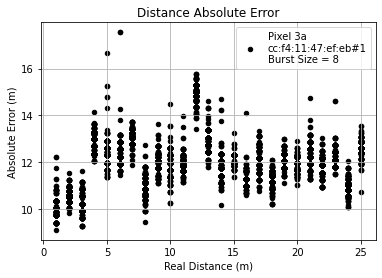

[Pixel 3a]Percentage of under-2M error for estimated distance:0.0


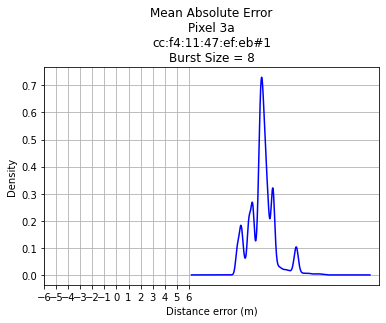

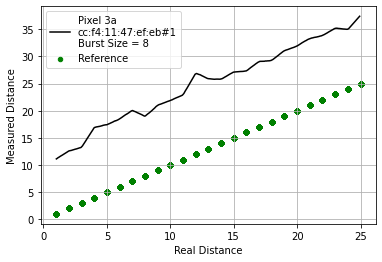

std reference point 1: 0.4508166920571555
std reference point 2: 0.2870102828949463
std reference point 3: 0.4838956124378135
std reference point 4: 0.4030663697780788
std reference point 5: 0.6878891040009972
std reference point 6: 0.6937308602079779
std reference point 7: 0.31535810332593817
std reference point 8: 0.48817877780194635
std reference point 9: 0.44695031348708625
std reference point 10: 0.616991419511553
std reference point 11: 0.3742377041766952
std reference point 12: 0.4041872409348783
std reference point 13: 0.47182652675853837
std reference point 14: 0.5951955448443572
std reference point 15: 0.25363540826656056
std reference point 16: 0.34945757983426445
std reference point 17: 0.5673053199904176
std reference point 18: 0.3623581167948141
std reference point 19: 0.32768137153173943
std reference point 20: 0.3246703391034639
std reference point 21: 0.5411501825327593
std reference point 22: 0.438817094299254
std reference point 23: 0.4318510260094358
std reference p

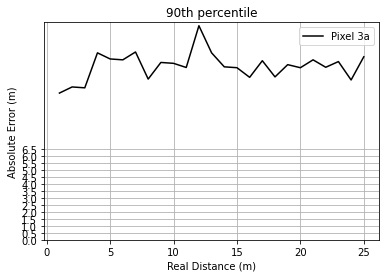

In [178]:
# Defining target UE
targetModel = ueDict["Pixel 3a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (2462MHz)"]

#Defining Color of the plot
color = "k"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

###  Removing bias

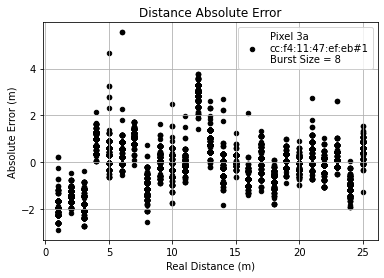

[Pixel 3a]Percentage of under-2M error for estimated distance:0.9235


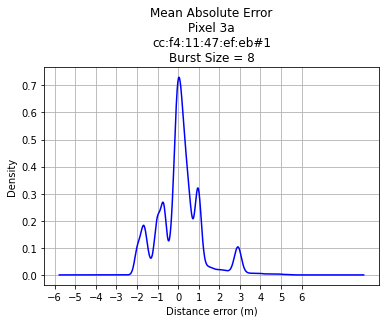

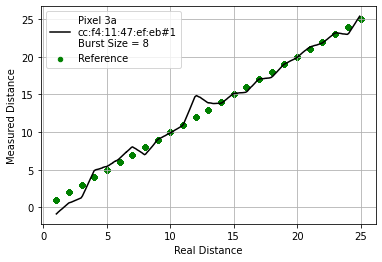

std reference point 1: 0.4508166920571555
std reference point 2: 0.2870102828949463
std reference point 3: 0.4838956124378135
std reference point 4: 0.4030663697780788
std reference point 5: 0.6878891040009972
std reference point 6: 0.6937308602079779
std reference point 7: 0.31535810332593817
std reference point 8: 0.48817877780194635
std reference point 9: 0.44695031348708625
std reference point 10: 0.616991419511553
std reference point 11: 0.3742377041766952
std reference point 12: 0.4041872409348783
std reference point 13: 0.47182652675853837
std reference point 14: 0.5951955448443572
std reference point 15: 0.25363540826656056
std reference point 16: 0.34945757983426445
std reference point 17: 0.5673053199904176
std reference point 18: 0.3623581167948141
std reference point 19: 0.32768137153173943
std reference point 20: 0.3246703391034639
std reference point 21: 0.5411501825327593
std reference point 22: 0.438817094299254
std reference point 23: 0.4318510260094358
std reference p

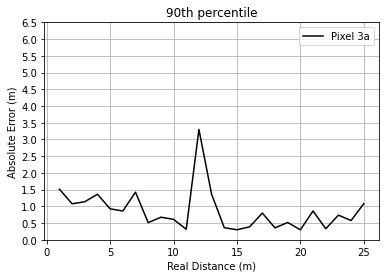

In [179]:
# Defining target UE
targetModel = ueDict["Pixel 3a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (2462MHz)"]

#Defining Color of the plot
color = "k"

#Defining bias
bias = 12

#Plotting measurements error
plotErrorBias(targetModel,targetAP,burstSize,bias, color)

#Plotting measurements trend
plotTrendBias(targetModel, targetAP, burstSize,bias, color)

#Plot 90th Qunatile
calculateQuantileBias(targetModel, targetAP, burstSize,quantile,color,bias)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

<b> Observation: </b> Removing a bias of 12 it looks better. References points lower than 4m present higher error.
    Reference points 13 and 14 in the main hall around the lift also presente higher error.

<table>
<tr>  
<td> <img src="./images/13.jpg" width="225" height="225"/> </td>
<td> <img src="./images/14.jpg" width="225" height="225"/> </td>   
</tr>
</table>

###  Pixel 4a - GRXCA-G06 (5180MHz) - Busrt Size = 8 

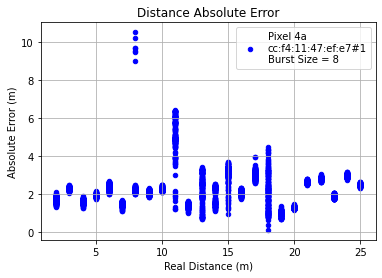

[Pixel 4a]Percentage of under-2M error for estimated distance:0.4021


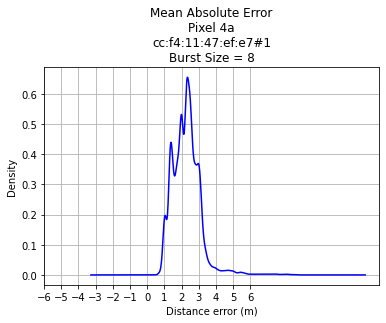

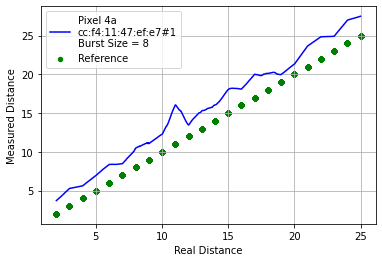

std reference point 1: nan
std reference point 2: 0.14835845413278492
std reference point 3: 0.0714901511296675
std reference point 4: 0.1098490622737038
std reference point 5: 0.06825151828892684
std reference point 6: 0.14843272412164746
std reference point 7: 0.099509751043623
std reference point 8: 1.3947384116245582
std reference point 9: 0.10521676010997588
std reference point 10: 0.0762273773622661
std reference point 11: 1.0463612635554447
std reference point 12: 0.10702952865515102
std reference point 13: 0.7581241318899864
std reference point 14: 0.4258731810811159
std reference point 15: 0.5123893727451406
std reference point 16: 0.1299979186754785
std reference point 17: 0.21006404040437676
std reference point 18: 0.945373414178853
std reference point 19: 0.12308351740274014
std reference point 20: 0.0523267937629994
std reference point 21: 0.06490788356248423
std reference point 22: 0.0695867941541096
std reference point 23: 0.07404660202437927
std reference point 24: 0.07

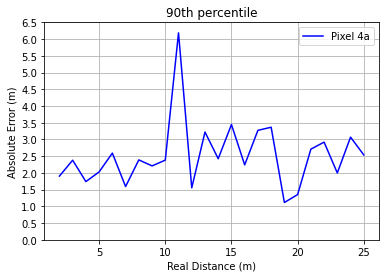

In [204]:
# Defining target UE
targetModel = ueDict["Pixel 4a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (5180MHz)"]

#Defining Color of the plot
color = "b"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

###  Removing bias

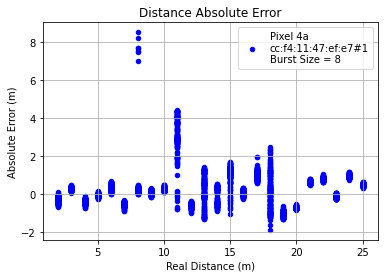

[Pixel 4a]Percentage of under-2M error for estimated distance:0.9606


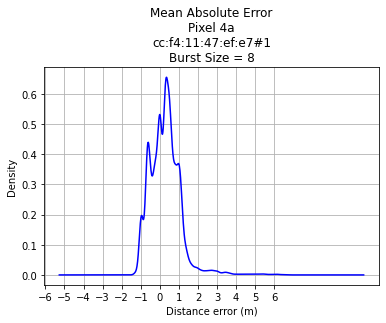

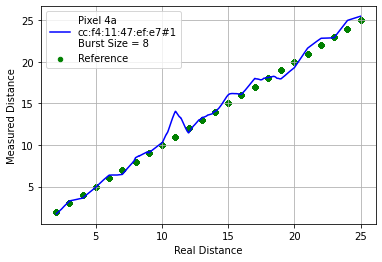

std reference point 1: nan
std reference point 2: 0.14835845413278492
std reference point 3: 0.0714901511296675
std reference point 4: 0.1098490622737038
std reference point 5: 0.06825151828892684
std reference point 6: 0.14843272412164746
std reference point 7: 0.099509751043623
std reference point 8: 1.3947384116245582
std reference point 9: 0.10521676010997588
std reference point 10: 0.0762273773622661
std reference point 11: 1.0463612635554447
std reference point 12: 0.10702952865515102
std reference point 13: 0.7581241318899864
std reference point 14: 0.4258731810811159
std reference point 15: 0.5123893727451406
std reference point 16: 0.1299979186754785
std reference point 17: 0.21006404040437676
std reference point 18: 0.945373414178853
std reference point 19: 0.12308351740274014
std reference point 20: 0.0523267937629994
std reference point 21: 0.06490788356248423
std reference point 22: 0.0695867941541096
std reference point 23: 0.07404660202437927
std reference point 24: 0.07

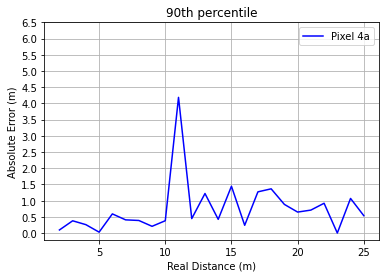

In [181]:
# Defining target UE
targetModel = ueDict["Pixel 4a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (5180MHz)"]

#Defining Color of the plot
color = "b"

#Defining bias
bias = 2

#Plotting measurements error
plotErrorBias(targetModel,targetAP,burstSize,bias, color)

#Plotting measurements trend
plotTrendBias(targetModel, targetAP, burstSize,bias, color)

#Plot 90th Qunatile
calculateQuantileBias(targetModel, targetAP, burstSize,quantile,color,bias)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

## Pixel 4a - GRXCA-L05 (5240MHz) - Busrt Size = 8 ##

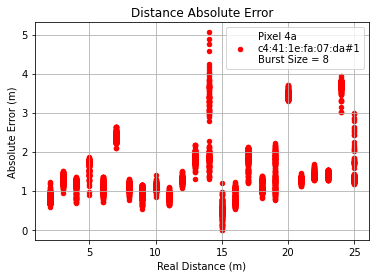

[Pixel 4a]Percentage of under-2M error for estimated distance:0.8362


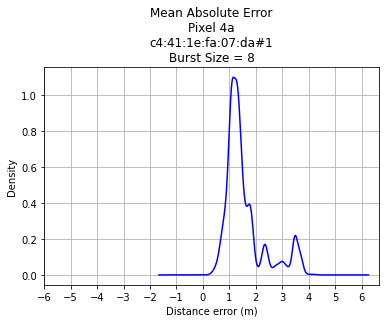

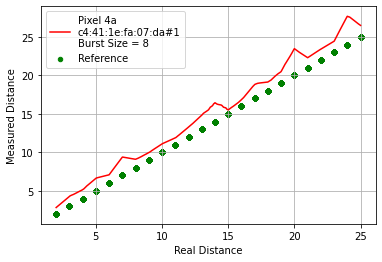

std reference point 1: nan
std reference point 2: 0.10996282194930827
std reference point 3: 0.1034681371157476
std reference point 4: 0.14834338520597767
std reference point 5: 0.16524662979143798
std reference point 6: 0.13981772706703816
std reference point 7: 0.10419037007606796
std reference point 8: 0.09844912965919644
std reference point 9: 0.13716041188485065
std reference point 10: 0.0714397027615127
std reference point 11: 0.08892438368014001
std reference point 12: 0.06867696858414694
std reference point 13: 0.13002361157986475
std reference point 14: 0.8909027401469819
std reference point 15: 0.19326270245128438
std reference point 16: 0.16833291493720515
std reference point 17: 0.21435590039739008
std reference point 18: 0.13623044321270567
std reference point 19: 0.39734604521849604
std reference point 20: 0.08909267928686707
std reference point 21: 0.05694999752556214
std reference point 22: 0.07873625433246913
std reference point 23: 0.0589064395299057
std reference poi

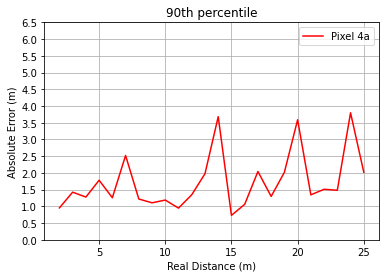

In [205]:
# Defining target UE
targetModel = ueDict["Pixel 4a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (5240MHz)"]

#Defining Color of the plot
color = "r"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

## Removing Bias

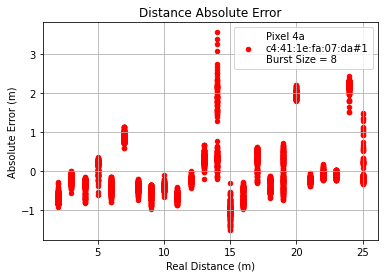

[Pixel 4a]Percentage of under-2M error for estimated distance:0.942


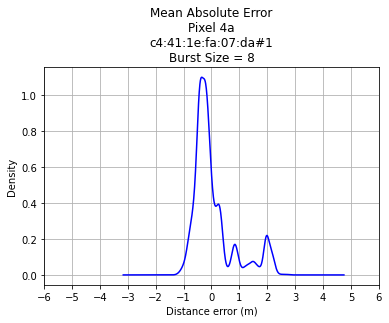

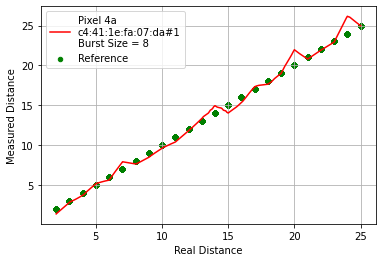

std reference point 1: nan
std reference point 2: 0.10996282194930827
std reference point 3: 0.1034681371157476
std reference point 4: 0.14834338520597767
std reference point 5: 0.16524662979143798
std reference point 6: 0.13981772706703816
std reference point 7: 0.10419037007606796
std reference point 8: 0.09844912965919644
std reference point 9: 0.13716041188485065
std reference point 10: 0.0714397027615127
std reference point 11: 0.08892438368014001
std reference point 12: 0.06867696858414694
std reference point 13: 0.13002361157986475
std reference point 14: 0.8909027401469819
std reference point 15: 0.19326270245128438
std reference point 16: 0.16833291493720515
std reference point 17: 0.21435590039739008
std reference point 18: 0.13623044321270567
std reference point 19: 0.39734604521849604
std reference point 20: 0.08909267928686707
std reference point 21: 0.05694999752556214
std reference point 22: 0.07873625433246913
std reference point 23: 0.0589064395299057
std reference poi

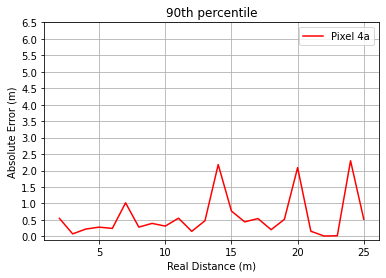

In [183]:
# Defining target UE
targetModel = ueDict["Pixel 4a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (5240MHz)"]

#Defining Color of the plot
color = "r"

#Defining bias
bias = 1.5

#Plotting measurements error
plotErrorBias(targetModel,targetAP,burstSize,bias, color)

#Plotting measurements trend
plotTrendBias(targetModel, targetAP, burstSize,bias, color)

#Plot 90th Qunatile
calculateQuantileBias(targetModel, targetAP, burstSize,quantile,color,bias)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

## Pixel 4a - GRXCA-L05 (5540MHz) - Busrt Size = 8

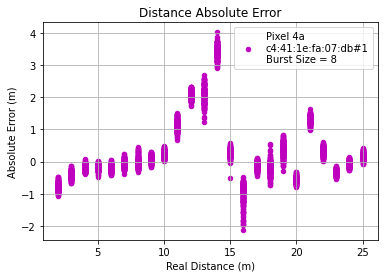

[Pixel 4a]Percentage of under-2M error for estimated distance:0.8999


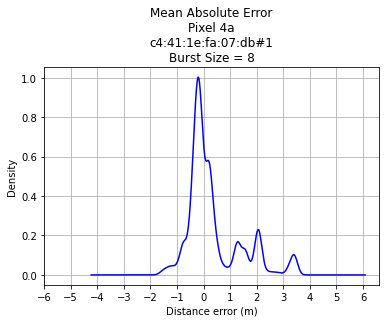

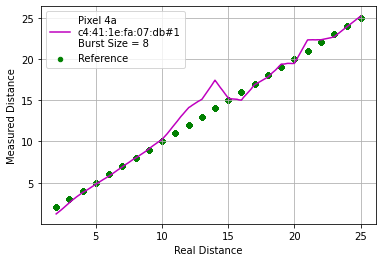

std reference point 1: nan
std reference point 2: 0.11851508385223593
std reference point 3: 0.10591770188624908
std reference point 4: 0.08946930694054867
std reference point 5: 0.08105567972745899
std reference point 6: 0.0908733195223165
std reference point 7: 0.10714707768428128
std reference point 8: 0.15548554837594655
std reference point 9: 0.09942730508005569
std reference point 10: 0.09652080451134668
std reference point 11: 0.16202797667727203
std reference point 12: 0.11949810862446353
std reference point 13: 0.26216472012341197
std reference point 14: 0.1897344861938817
std reference point 15: 0.12353911484959913
std reference point 16: 0.32244917826666025
std reference point 17: 0.11050689227919674
std reference point 18: 0.20478499842002448
std reference point 19: 0.21623212303020736
std reference point 20: 0.08559136864739725
std reference point 21: 0.11258978110467031
std reference point 22: 0.11432954000866517
std reference point 23: 0.0755249691387086
std reference po

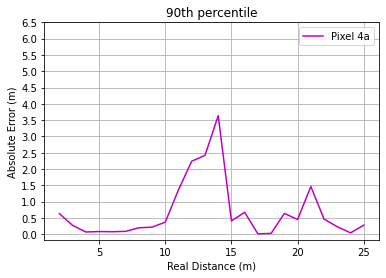

In [206]:
# Defining target UE
targetModel = ueDict["Pixel 4a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (5540MHz)"]

#Defining Color of the plot
color = "m"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

## Pixel 4a - GRXCA-G06 (2462MHz) - Busrt Size = 8

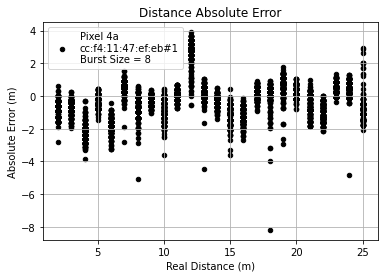

[Pixel 4a]Percentage of under-2M error for estimated distance:0.9049


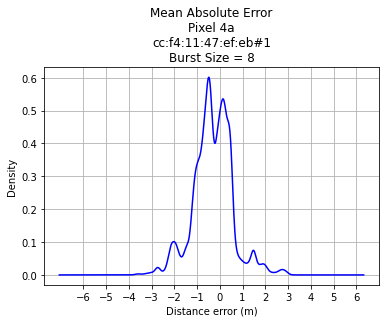

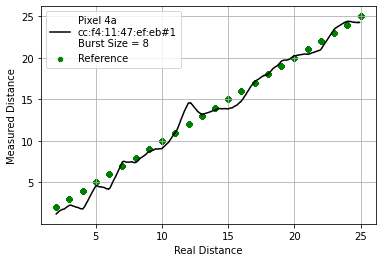

std reference point 1: nan
std reference point 2: 0.4734464814350287
std reference point 3: 0.4298587508534393
std reference point 4: 0.5667887735057378
std reference point 5: 0.37568872484432125
std reference point 6: 0.5187506219284325
std reference point 7: 0.47701812004713673
std reference point 8: 0.6853409826400128
std reference point 9: 0.2794907154935485
std reference point 10: 0.6606264577966202
std reference point 11: 0.3154728737708093
std reference point 12: 0.8529280327604144
std reference point 13: 0.5094813592490336
std reference point 14: 0.33702848599202523
std reference point 15: 0.5815978241519855
std reference point 16: 0.4963742623697624
std reference point 17: 0.342610734346601
std reference point 18: 0.9229928675821505
std reference point 19: 0.6781173567573298
std reference point 20: 0.36979741165597635
std reference point 21: 0.6437542934192892
std reference point 22: 0.5262522698567168
std reference point 23: 0.3555745641623689
std reference point 24: 0.555934

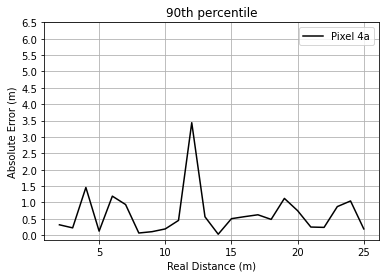

In [207]:
# Defining target UE
targetModel = ueDict["Pixel 4a"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (2462MHz)"]

#Defining Color of the plot
color = "k"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

###  Pixel 6 Pro - GRXCA-G06 (5180MHz) - Busrt Size = 8 

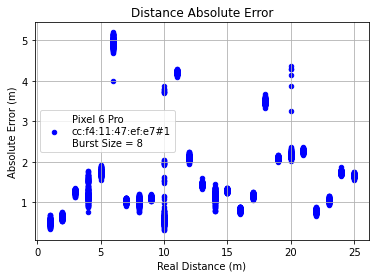

[Pixel 6 Pro]Percentage of under-2M error for estimated distance:0.7182


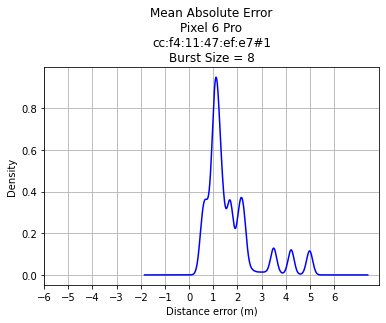

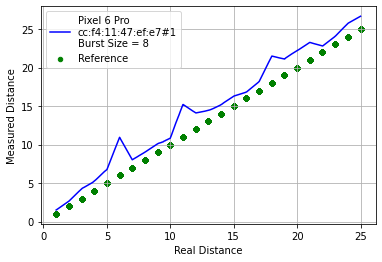

std reference point 1: 0.060337056623687324
std reference point 2: 0.04427450886998512
std reference point 3: 0.03518865166541831
std reference point 4: 0.2140553161964444
std reference point 5: 0.061703986986662795
std reference point 6: 0.12413933642986102
std reference point 7: 0.037989116399623254
std reference point 8: 0.08344980376695751
std reference point 9: 0.031315183274532955
std reference point 10: 0.7447053027302631
std reference point 11: 0.03351495541069545
std reference point 12: 0.050762329244743686
std reference point 13: 0.03669888849931875
std reference point 14: 0.12228059995611794
std reference point 15: 0.028998561305501876
std reference point 16: 0.03441367614085474
std reference point 17: 0.038210721942365675
std reference point 18: 0.050862701926226696
std reference point 19: 0.03128838787921814
std reference point 20: 0.33098612668097793
std reference point 21: 0.031596187989651366
std reference point 22: 0.03997798891877806
std reference point 23: 0.03808770

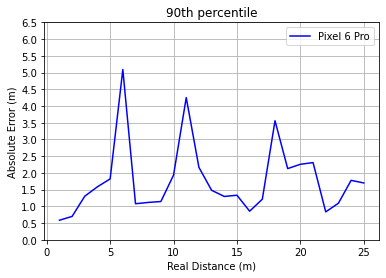

In [186]:
# Defining target UE
targetModel = ueDict["Pixel 6 Pro"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (5180MHz)"]

#Defining Color of the plot
color = "b"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

## Removign Bias

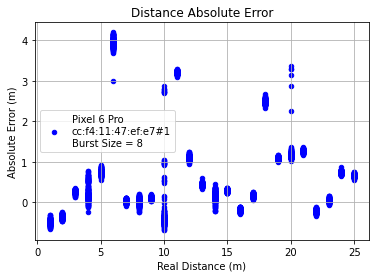

[Pixel 6 Pro]Percentage of under-2M error for estimated distance:0.877


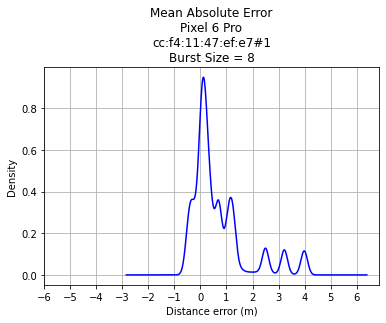

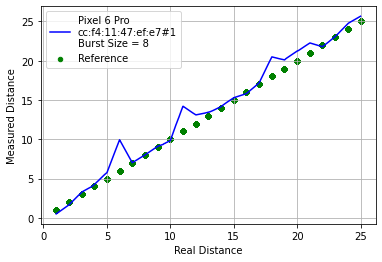

std reference point 1: 0.060337056623687324
std reference point 2: 0.04427450886998512
std reference point 3: 0.03518865166541831
std reference point 4: 0.2140553161964444
std reference point 5: 0.061703986986662795
std reference point 6: 0.12413933642986102
std reference point 7: 0.037989116399623254
std reference point 8: 0.08344980376695751
std reference point 9: 0.031315183274532955
std reference point 10: 0.7447053027302631
std reference point 11: 0.03351495541069545
std reference point 12: 0.050762329244743686
std reference point 13: 0.03669888849931875
std reference point 14: 0.12228059995611794
std reference point 15: 0.028998561305501876
std reference point 16: 0.03441367614085474
std reference point 17: 0.038210721942365675
std reference point 18: 0.050862701926226696
std reference point 19: 0.03128838787921814
std reference point 20: 0.33098612668097793
std reference point 21: 0.031596187989651366
std reference point 22: 0.03997798891877806
std reference point 23: 0.03808770

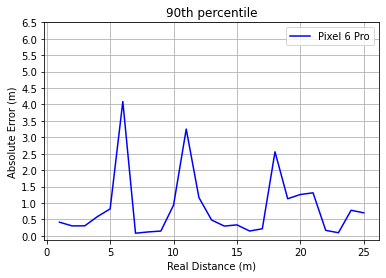

In [187]:
# Defining target UE
targetModel = ueDict["Pixel 6 Pro"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (5180MHz)"]

#Defining Color of the plot
color = "b"

#Defining bias
bias = 1

#Plotting measurements error
plotErrorBias(targetModel,targetAP,burstSize,bias, color)

#Plotting measurements trend
plotTrendBias(targetModel, targetAP, burstSize,bias, color)

#Plot 90th Qunatile
calculateQuantileBias(targetModel, targetAP, burstSize,quantile,color,bias)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

###  Pixel 6 Pro - GRXCA-L05 (5540MHz) - Busrt Size = 8 

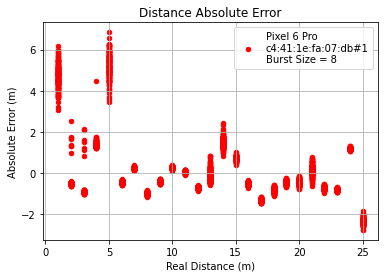

[Pixel 6 Pro]Percentage of under-2M error for estimated distance:0.8793


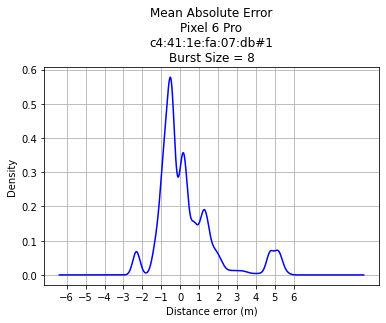

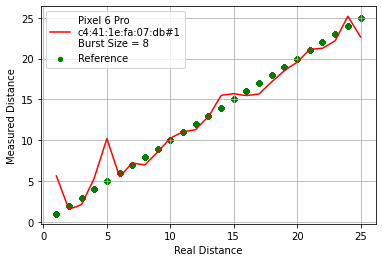

std reference point 1: 0.5407549997494757
std reference point 2: 0.42549865472446124
std reference point 3: 0.45710454078474233
std reference point 4: 0.2410264985565827
std reference point 5: 0.5549428594560943
std reference point 6: 0.053968406066491295
std reference point 7: 0.041742052774740794
std reference point 8: 0.059948662960500936
std reference point 9: 0.05055119613107813
std reference point 10: 0.04392247052575055
std reference point 11: 0.04445906270380174
std reference point 12: 0.04789274842561026
std reference point 13: 0.2860279031965853
std reference point 14: 0.22384196573266774
std reference point 15: 0.08705065757893288
std reference point 16: 0.061737530834718654
std reference point 17: 0.06281381837537402
std reference point 18: 0.1010180936825491
std reference point 19: 0.08127447818362236
std reference point 20: 0.11408240475803826
std reference point 21: 0.24330751775381512
std reference point 22: 0.06777408526247931
std reference point 23: 0.0485983135551225

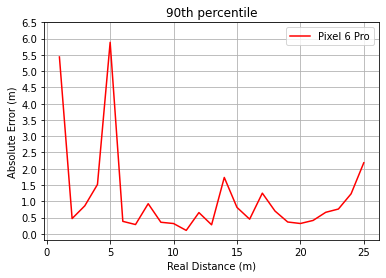

In [188]:
# Defining target UE
targetModel = ueDict["Pixel 6 Pro"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (5540MHz)"]

#Defining Color of the plot
color = "r"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

###  Xiaomi Mi 10T - GRXCA-G06 (5180MHz)- Busrt Size = 8

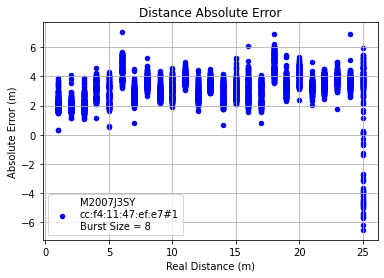

[M2007J3SY]Percentage of under-2M error for estimated distance:0.0688


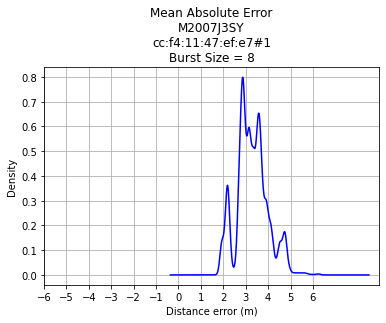

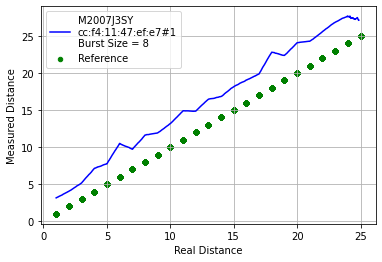

std reference point 1: 0.52030268886505
std reference point 2: 0.4184120342005289
std reference point 3: 0.4696648688641999
std reference point 4: 0.5452880538839474
std reference point 5: 0.6647680902722551
std reference point 6: 0.6442343747020479
std reference point 7: 0.46620006435005995
std reference point 8: 0.38367795459108145
std reference point 9: 0.44984922080560813
std reference point 10: 0.5648180971448912
std reference point 11: 0.3625470776093388
std reference point 12: 0.4695277102883739
std reference point 13: 0.32641427229948755
std reference point 14: 0.5941579149641725
std reference point 15: 0.5921437190582203
std reference point 16: 0.7692954221936071
std reference point 17: 0.642372624606794
std reference point 18: 0.6806219781891054
std reference point 19: 0.5335394547019163
std reference point 20: 0.5233682274532316
std reference point 21: 0.3314346929837758
std reference point 22: 0.46086202142175337
std reference point 23: 0.39139515998065355
std reference poi

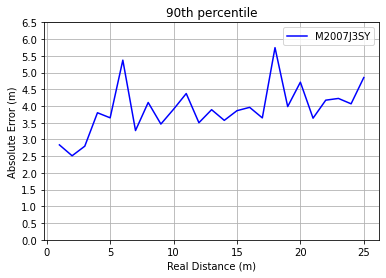

In [189]:
# Defining target UE
targetModel = ueDict["Xiaomi Mi 10T"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (5180MHz)"]

#Defining Color of the plot
color = "b"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

## Removing Bias

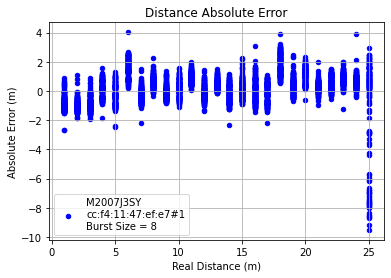

[M2007J3SY]Percentage of under-2M error for estimated distance:0.9549


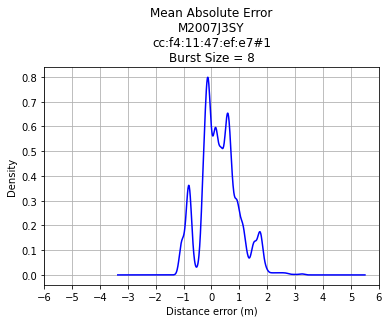

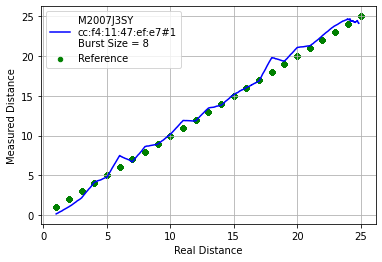

std reference point 1: 0.52030268886505
std reference point 2: 0.4184120342005289
std reference point 3: 0.4696648688641999
std reference point 4: 0.5452880538839474
std reference point 5: 0.6647680902722551
std reference point 6: 0.6442343747020479
std reference point 7: 0.46620006435005995
std reference point 8: 0.38367795459108145
std reference point 9: 0.44984922080560813
std reference point 10: 0.5648180971448912
std reference point 11: 0.3625470776093388
std reference point 12: 0.4695277102883739
std reference point 13: 0.32641427229948755
std reference point 14: 0.5941579149641725
std reference point 15: 0.5921437190582203
std reference point 16: 0.7692954221936071
std reference point 17: 0.642372624606794
std reference point 18: 0.6806219781891054
std reference point 19: 0.5335394547019163
std reference point 20: 0.5233682274532316
std reference point 21: 0.3314346929837758
std reference point 22: 0.46086202142175337
std reference point 23: 0.39139515998065355
std reference poi

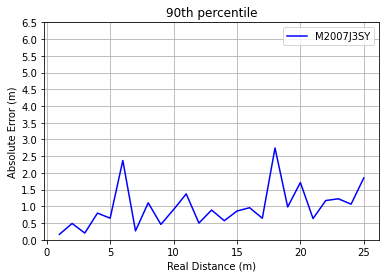

In [190]:
# Defining target UE
targetModel = ueDict["Xiaomi Mi 10T"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (5180MHz)"]

#Defining Color of the plot
color = "b"

#Defining bias
bias = 3

#Plotting measurements error
plotErrorBias(targetModel,targetAP,burstSize,bias, color)

#Plotting measurements trend
plotTrendBias(targetModel, targetAP, burstSize,bias, color)

#Plot 90th Qunatile
calculateQuantileBias(targetModel, targetAP, burstSize,quantile,color,bias)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

###  Xiaomi Mi 10T - GRXCA-L05 (5540MHz) - Busrt Size = 8

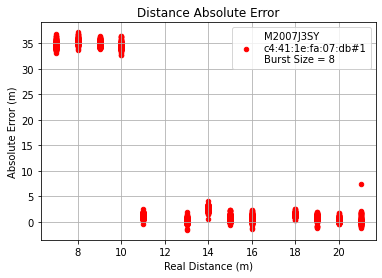

[M2007J3SY]Percentage of under-2M error for estimated distance:0.5975


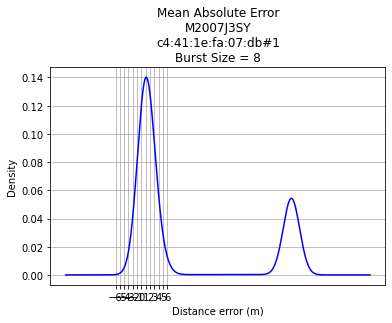

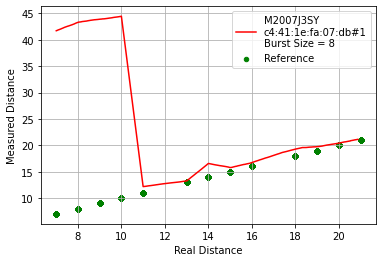

std reference point 1: nan
std reference point 2: nan
std reference point 3: nan
std reference point 4: nan
std reference point 5: nan
std reference point 6: nan
std reference point 7: 0.620600837391145
std reference point 8: 0.5302334856897798
std reference point 9: 0.5252508869542546
std reference point 10: 0.6190637797651266
std reference point 11: 0.44450081492879384
std reference point 12: nan
std reference point 13: 0.4821994685244971
std reference point 14: 0.4689775475441254
std reference point 15: 0.596618841581324
std reference point 16: 0.6374219767611151
std reference point 17: nan
std reference point 18: 0.3790528021912481
std reference point 19: 0.5303386421682702
std reference point 20: 0.40337366693412136
std reference point 21: 0.8032834070566534
std reference point 22: nan
std reference point 23: nan
std reference point 24: nan
std reference point 25: nan
Max std M2007J3SY: nan
Mean std M2007J3SY: nan


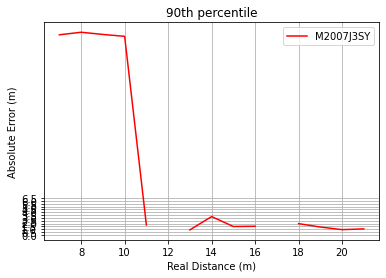

In [191]:
# Defining target UE
targetModel = ueDict["Xiaomi Mi 10T"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (5540MHz)"]

#Defining Color of the plot
color = "r"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

###  Xiaomi Mi 10T - GRXCA-L05 (5240MHz) - Busrt Size = 8

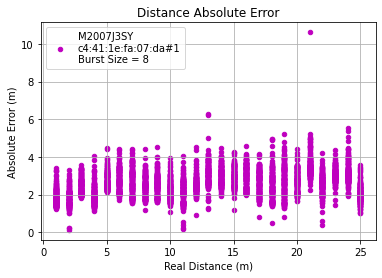

[M2007J3SY]Percentage of under-2M error for estimated distance:0.207


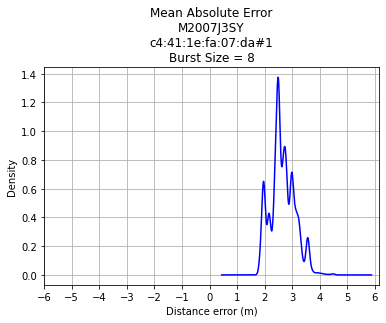

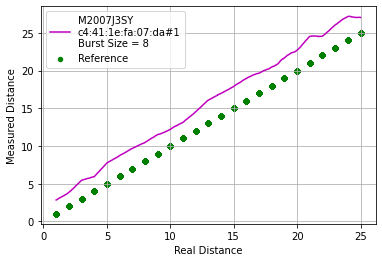

std reference point 1: 0.418974884862719
std reference point 2: 0.4877013378011482
std reference point 3: 0.4150165984450798
std reference point 4: 0.4731432622717625
std reference point 5: 0.43073977963942356
std reference point 6: 0.5636807578397492
std reference point 7: 0.6835100003859459
std reference point 8: 0.5096728751841639
std reference point 9: 0.5249220281893225
std reference point 10: 0.49652624822448155
std reference point 11: 0.5949267699887343
std reference point 12: 0.421021091833887
std reference point 13: 0.6413895715352931
std reference point 14: 0.46826525405112707
std reference point 15: 0.4871529817344973
std reference point 16: 0.5775912932124432
std reference point 17: 0.5850621922659979
std reference point 18: 0.7395204212553492
std reference point 19: 0.8347234606916326
std reference point 20: 0.5460924941443565
std reference point 21: 0.7139497177474524
std reference point 22: 0.5220502737692849
std reference point 23: 0.37124389283612935
std reference poin

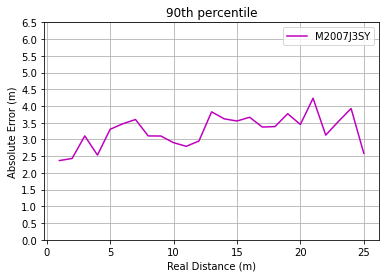

In [192]:
# Defining target UE
targetModel = ueDict["Xiaomi Mi 10T"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (5240MHz)"]

#Defining Color of the plot
color = "m"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

## Removing Bias

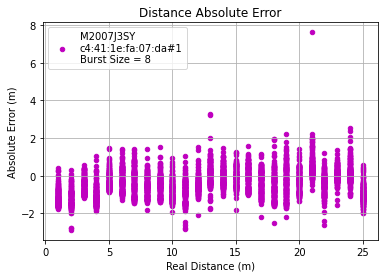

[M2007J3SY]Percentage of under-2M error for estimated distance:0.9953


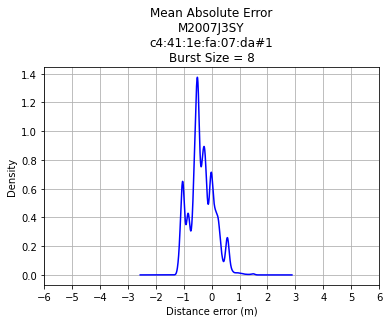

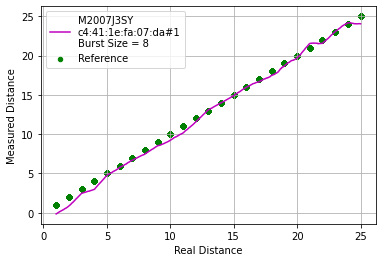

std reference point 1: 0.418974884862719
std reference point 2: 0.4877013378011482
std reference point 3: 0.4150165984450798
std reference point 4: 0.4731432622717625
std reference point 5: 0.43073977963942356
std reference point 6: 0.5636807578397492
std reference point 7: 0.6835100003859459
std reference point 8: 0.5096728751841639
std reference point 9: 0.5249220281893225
std reference point 10: 0.49652624822448155
std reference point 11: 0.5949267699887343
std reference point 12: 0.421021091833887
std reference point 13: 0.6413895715352931
std reference point 14: 0.46826525405112707
std reference point 15: 0.4871529817344973
std reference point 16: 0.5775912932124432
std reference point 17: 0.5850621922659979
std reference point 18: 0.7395204212553492
std reference point 19: 0.8347234606916326
std reference point 20: 0.5460924941443565
std reference point 21: 0.7139497177474524
std reference point 22: 0.5220502737692849
std reference point 23: 0.37124389283612935
std reference poin

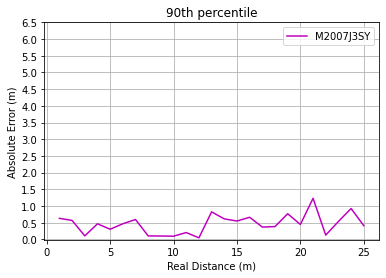

In [193]:
# Defining target UE
targetModel = ueDict["Xiaomi Mi 10T"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (5240MHz)"]

#Defining Color of the plot
color = "m"

#Defining bias
bias = 3

#Plotting measurements error
plotErrorBias(targetModel,targetAP,burstSize,bias, color)

#Plotting measurements trend
plotTrendBias(targetModel, targetAP, burstSize,bias, color)

#Plot 90th Qunatile
calculateQuantileBias(targetModel, targetAP, burstSize,quantile,color,bias)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

###  Xiaomi Mi 10T - GRXCA-G06 (2462MHz) - Busrt Size = 8

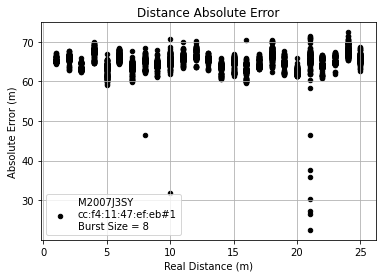

[M2007J3SY]Percentage of under-2M error for estimated distance:0.0


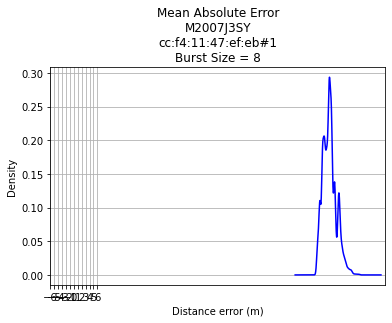

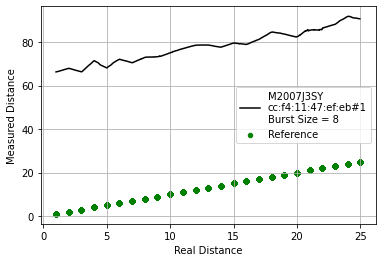

std reference point 1: 0.42136578494654503
std reference point 2: 0.7021863107424998
std reference point 3: 0.6184102104119148
std reference point 4: 1.0266496693532017
std reference point 5: 1.43006477553298
std reference point 6: 0.8931919822106708
std reference point 7: 1.1108141956008522
std reference point 8: 1.685523248691244
std reference point 9: 0.8687124254699188
std reference point 10: 2.6554758702700054
std reference point 11: 0.7931513467410247
std reference point 12: 1.01301882537033
std reference point 13: 0.6247780793929757
std reference point 14: 0.9141987261731896
std reference point 15: 1.107683493210451
std reference point 16: 1.3104843745023331
std reference point 17: 0.8132119115367941
std reference point 18: 1.3064640537953363
std reference point 19: 0.9917401636408194
std reference point 20: 0.699337307825578
std reference point 21: 6.858472993455272
std reference point 22: 1.1747217103535503
std reference point 23: 0.8394957618366141
std reference point 24: 1.3

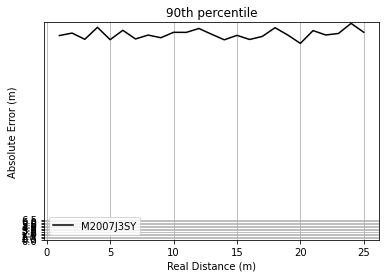

In [194]:
# Defining target UE
targetModel = ueDict["Xiaomi Mi 10T"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (2462MHz)"]

#Defining Color of the plot
color = "k"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

## Removing Bias

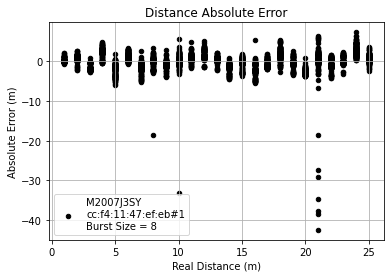

[M2007J3SY]Percentage of under-2M error for estimated distance:0.7592


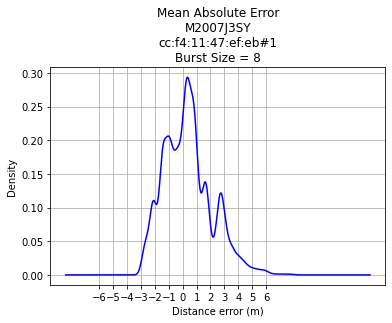

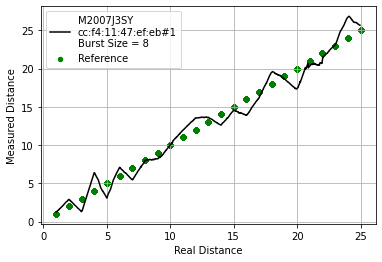

std reference point 1: 0.42136578494654503
std reference point 2: 0.7021863107424998
std reference point 3: 0.6184102104119148
std reference point 4: 1.0266496693532017
std reference point 5: 1.43006477553298
std reference point 6: 0.8931919822106708
std reference point 7: 1.1108141956008522
std reference point 8: 1.685523248691244
std reference point 9: 0.8687124254699188
std reference point 10: 2.6554758702700054
std reference point 11: 0.7931513467410247
std reference point 12: 1.01301882537033
std reference point 13: 0.6247780793929757
std reference point 14: 0.9141987261731896
std reference point 15: 1.107683493210451
std reference point 16: 1.3104843745023331
std reference point 17: 0.8132119115367941
std reference point 18: 1.3064640537953363
std reference point 19: 0.9917401636408194
std reference point 20: 0.699337307825578
std reference point 21: 6.858472993455272
std reference point 22: 1.1747217103535503
std reference point 23: 0.8394957618366141
std reference point 24: 1.3

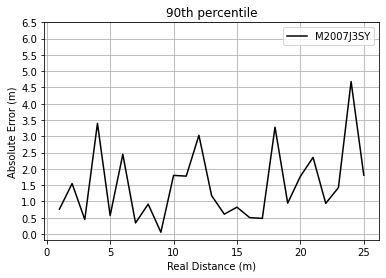

In [195]:
# Defining target UE
targetModel = ueDict["Xiaomi Mi 10T"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-G06 (2462MHz)"]

#Defining Color of the plot
color = "k"

#Defining bias
bias = 65

#Plotting measurements error
plotErrorBias(targetModel,targetAP,burstSize,bias, color)

#Plotting measurements trend
plotTrendBias(targetModel, targetAP, burstSize,bias, color)

#Plot 90th Qunatile
calculateQuantileBias(targetModel, targetAP, burstSize,quantile,color,bias)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

###  Xiaomi Mi 10T - GRXCA-L05 (2427MHz) - Busrt Size = 8

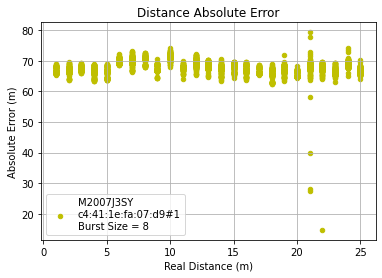

[M2007J3SY]Percentage of under-2M error for estimated distance:0.0


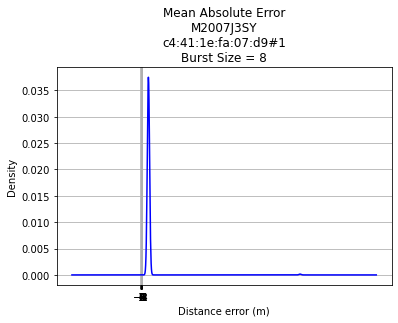

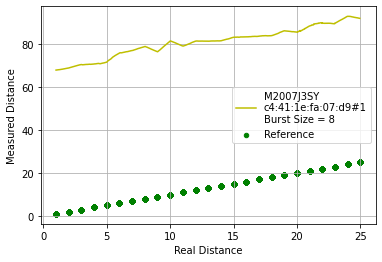

std reference point 1: 0.7948201766222527
std reference point 2: 0.9384510379297053
std reference point 3: 0.6452428001385618
std reference point 4: 1.181756071291861
std reference point 5: 1.268082918588956
std reference point 6: 0.76431196365682
std reference point 7: 1.2143438035172343
std reference point 8: 0.9452459590768476
std reference point 9: 0.8974490469852168
std reference point 10: 0.9124546326575862
std reference point 11: 0.6498387612926702
std reference point 12: 1.2107452165681547
std reference point 13: 0.9892786235180407
std reference point 14: 1.114738456228924
std reference point 15: 1.0648816184456322
std reference point 16: 1.0950816954756732
std reference point 17: 0.7425233543524364
std reference point 18: 1.304571080810883
std reference point 19: 1.1435114267107245
std reference point 20: 0.7902524092030694
std reference point 21: 4.958633644852112
std reference point 22: 3.8797119046930644
std reference point 23: 0.9676185823335106
std reference point 24: 1.0

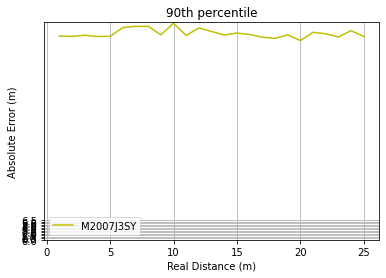

In [196]:
# Defining target UE
targetModel = ueDict["Xiaomi Mi 10T"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (2427MHz)"]

#Defining Color of the plot
color = "y"

#Plotting measurements error
plotError(targetModel,targetAP,burstSize,color)

#Plotting measurements trend
plotTrend(targetModel, targetAP, burstSize, color)

#Plot 90th Qunatile
calculateQuantile(targetModel, targetAP, burstSize,quantile,color)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)

## Removing Bias

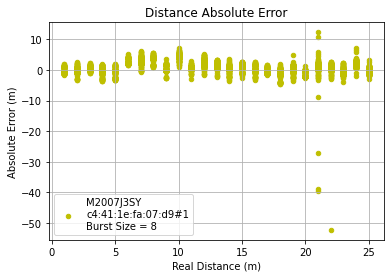

[M2007J3SY]Percentage of under-2M error for estimated distance:0.7349


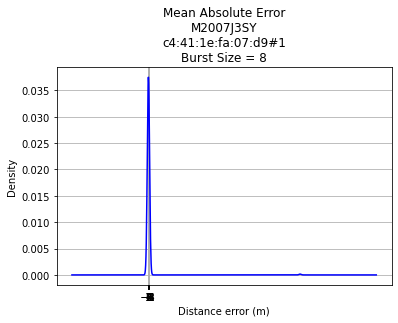

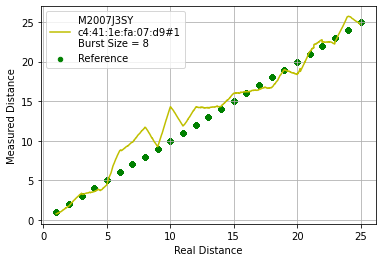

std reference point 1: 0.7948201766222527
std reference point 2: 0.9384510379297053
std reference point 3: 0.6452428001385618
std reference point 4: 1.181756071291861
std reference point 5: 1.268082918588956
std reference point 6: 0.76431196365682
std reference point 7: 1.2143438035172343
std reference point 8: 0.9452459590768476
std reference point 9: 0.8974490469852168
std reference point 10: 0.9124546326575862
std reference point 11: 0.6498387612926702
std reference point 12: 1.2107452165681547
std reference point 13: 0.9892786235180407
std reference point 14: 1.114738456228924
std reference point 15: 1.0648816184456322
std reference point 16: 1.0950816954756732
std reference point 17: 0.7425233543524364
std reference point 18: 1.304571080810883
std reference point 19: 1.1435114267107245
std reference point 20: 0.7902524092030694
std reference point 21: 4.958633644852112
std reference point 22: 3.8797119046930644
std reference point 23: 0.9676185823335106
std reference point 24: 1.0

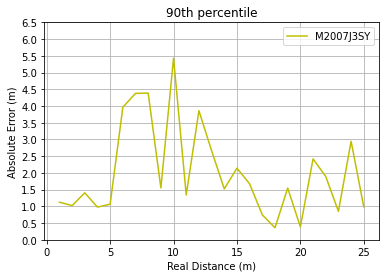

In [197]:
# Defining target UE
targetModel = ueDict["Xiaomi Mi 10T"]

# Defining target AP and Frequeny Band
targetAP = apDict["GRXCA-L05 (2427MHz)"]

#Defining Color of the plot
color = "y"

#Defining bias
bias = 67

#Plotting measurements error
plotErrorBias(targetModel,targetAP,burstSize,bias, color)

#Plotting measurements trend
plotTrendBias(targetModel, targetAP, burstSize,bias, color)

#Plot 90th Qunatile
calculateQuantileBias(targetModel, targetAP, burstSize,quantile,color,bias)

#Max standard deviation
calculateStandardDeviation(targetModel, targetAP, burstSize)